# Elastic-Net Logistic Regression —-(Fraud Detection)

**Goal**: Exploring Machine Learning Techniques for Insurance Fraud Detection


## 1) Imports & Configuration

In [1]:
import os, json, warnings
from datetime import datetime
from pathlib import Path
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_predict
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, classification_report,
    precision_recall_curve, roc_curve, confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.calibration import calibration_curve

warnings.filterwarnings('ignore')

DATA_PATH   = 'Worksheet in Case Study question 2.xlsx'  # adjust if needed
TARGET      = 'fraud_reported'
SEED        = 42
OUT_DIR     = Path('outputs_elasticnet_step')
MODEL_NAME  = 'logreg_elasticnet'
MODEL_FILE  = OUT_DIR / f'{MODEL_NAME}_best.joblib'
METRICS_LOG = Path('metrics.jsonl')

OUT_DIR.mkdir(parents=True, exist_ok=True)
print('Output directory:', OUT_DIR.resolve())


Output directory: /Users/ashleychen/Documents/western_MDA/DS9000/DS9000-Project/archive/outputs_elasticnet_step


## 2) Load the dataset


In [2]:
# Read the Excel. Ensure the file is placed next to this notebook or update DATA_PATH.
df = pd.read_excel(DATA_PATH, sheet_name=0)
assert TARGET in df.columns, f"Target column '{TARGET}' not found."
df.head()

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,...,2,YES,71610,6510,13020,52080,Saab,92x,2004,Y
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,...,0,?,5070,780,780,3510,Mercedes,E400,2007,Y
2,134,29,687698,2000-09-06,OH,100/300,2000,1413.14,5000000,430632,...,3,NO,34650,7700,3850,23100,Dodge,RAM,2007,N
3,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,608117,...,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y
4,228,44,367455,2014-06-06,IL,500/1000,1000,1583.91,6000000,610706,...,1,NO,6500,1300,650,4550,Accura,RSX,2009,N


## 2.5) Clean the dataset

In [3]:
# replace '?' with NaN
df = df.replace('?', np.nan)
# Check missing values
df.isna().sum().sort_values(ascending=False).head(10)

property_damage            360
police_report_available    343
collision_type             178
authorities_contacted       91
months_as_customer           0
age                          0
policy_number                0
policy_deductable            0
policy_csl                   0
policy_state                 0
dtype: int64

In [4]:
cols = ['collision_type', 'property_damage', 'police_report_available', 'authorities_contacted']
for c in cols:
    if c in df.columns:
        df[c] = df[c].fillna('Unknown')

In [5]:
df.isna().sum().sort_values(ascending=False).head(10)

months_as_customer       0
age                      0
policy_number            0
policy_bind_date         0
policy_state             0
policy_csl               0
policy_deductable        0
policy_annual_premium    0
umbrella_limit           0
insured_zip              0
dtype: int64

## 3) Checking class balance

In [6]:
# Normalize=True shows proportions (Y vs N)
TARGET = "fraud_reported"   
POS    = "Y"                # positive label (fraud)

s = df[TARGET].value_counts(normalize=True).rename("proportion")
display(s)                  

major = s.idxmax()
print(f"The split is roughly {s[major]:.0%}-{1-s[major]:.0%} in favor of {major}.")
print(f"Positive rate ({POS}): {s.get(POS, 0):.1%}")


fraud_reported
N    0.753
Y    0.247
Name: proportion, dtype: float64

The split is roughly 75%-25% in favor of N.
Positive rate (Y): 24.7%


## 4) Drop identifiers and free-text location fields (high-cardinality / leak risk)

In [7]:
# Adjust this list based on schema. We avoid using near-unique IDs and raw addresses.
ID_COLS = ['policy_number', 'incident_location', 'insured_zip']
df = df.drop(columns=[c for c in ID_COLS if c in df.columns])



## 5) Derive interpretable features from dates/times

In [8]:
# 1) Parse dates
for col in ['policy_bind_date', 'incident_date']:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

# 2) Tenure in days: incident_date - policy_bind_date
if {'policy_bind_date','incident_date'}.issubset(df.columns):
    df['policy_tenure_days'] = (df['incident_date'] - df['policy_bind_date']).dt.days

# 3) Hour of day: dataset already has 'incident_hour_of_the_day' (0–23)
if 'incident_hour_of_the_day' in df.columns:
    df['incident_hour'] = pd.to_numeric(df['incident_hour_of_the_day'], errors='coerce')
else:
    df['incident_hour'] = np.nan  # fallback if the column is missing

# 4) After creating useful signals, drop the raw date/time columns to avoid high cardinality/redundancy
to_drop_after_fe = [c for c in ['policy_bind_date','incident_date','incident_hour_of_the_day'] if c in df.columns]
df = df.drop(columns=to_drop_after_fe)

# 5) Quick preview
df[['policy_tenure_days','incident_hour']].head()


,policy_tenure_days,incident_hour
0,100,5
1,3130,8
2,5282,7
3,8996,5
4,256,20


## 6) Check data types

In [9]:
df.dtypes

months_as_customer               int64
age                              int64
policy_state                    object
policy_csl                      object
policy_deductable                int64
policy_annual_premium          float64
umbrella_limit                   int64
insured_sex                     object
insured_education_level         object
insured_occupation              object
insured_hobbies                 object
insured_relationship            object
capital-gains                    int64
capital-loss                     int64
incident_type                   object
collision_type                  object
incident_severity               object
authorities_contacted           object
incident_state                  object
incident_city                   object
number_of_vehicles_involved      int64
property_damage                 object
bodily_injuries                  int64
witnesses                        int64
police_report_available         object
total_claim_amount       

## 7) Prepare `X` and `y`
Create the **feature matrix `X`** and the **label vector `y`**.  
- Encode the target `fraud_reported` as **1 for 'Y'** and **0 for 'N'** so scikit-learn can train.  
- **Drop rows with missing target** to avoid training on unlabeled data.  
- `X.shape, y.mean()` prints the dataset size and the **positive rate** (baseline fraud rate).

In [10]:
# Map target to {0,1}; drop rows with missing target
df = df.dropna(subset=[TARGET]).copy()
y = df[TARGET].astype(str).str.upper().map({'Y':1,'N':0}).astype(int)
X = df.drop(columns=[TARGET])
X.shape, y.mean()

((1000, 34), np.float64(0.247))

## 8) Train/Validation/Test split

In [11]:
SEED = 42
TEST_SIZE = 0.20

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=SEED, stratify=y
)

## 9) Preprocess: fit on training set (numeric = median+scale, categorical = mode+one-hot)

In [13]:
# 1) Identify columns from X_train (single Train/Test split)
num_cols = X_train.select_dtypes(include=['number','float','int','bool']).columns.tolist()
cat_cols = X_train.select_dtypes(include=['object','category']).columns.tolist()

# 2) Ensure these are treated as categorical even if stored as numbers
for c in ['insured_zip', 'policy_state', 'policy_csl']:
    if c in X_train.columns and c in num_cols:
        num_cols.remove(c)
        cat_cols.append(c)

# 3) Simple pipelines
numeric_pipe = Pipeline([
    ('imp', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipe = Pipeline([
    ('imp', SimpleImputer(strategy='most_frequent')),   
    ('oh', OneHotEncoder(handle_unknown='ignore'
                         #, sparse=True
                         ))
])

# 4) Column-wise transformer
pre = ColumnTransformer([
    ('num', numeric_pipe, num_cols),
    ('cat', categorical_pipe, cat_cols)
])

print(f"Numeric: {len(num_cols)} | Categorical: {len(cat_cols)}")

Numeric: 17 | Categorical: 17


## 10) Model (single split): Elastic-Net Logistic Regression



In [14]:
# Ensure categorical columns are strings (avoid mixed int/str for OneHotEncoder)
cat_cols_fix = X_train.select_dtypes(include=['object','category']).columns.tolist()
cat_cols_fix = sorted(set(cat_cols_fix ))


X_train[cat_cols_fix] = X_train[cat_cols_fix].astype(str)
X_test[cat_cols_fix]  = X_test[cat_cols_fix].astype(str)


In [16]:
SEED = 42 

clf = Pipeline([
    ('prep', pre),
    ('clf', LogisticRegression(
        penalty='elasticnet', solver='saga',
        l1_ratio=0.5, C=1.0, class_weight='balanced',
        max_iter=4000, random_state=SEED
    ))
])


clf.fit(X_train, y_train)

proba_test = clf.predict_proba(X_test)[:, 1]

y_pred = clf.predict(X_test)

# metrics
acc  = accuracy_score(y_test, y_pred)
auc  = roc_auc_score(y_test, proba_test)                   # ROC-AUC
prec = precision_score(y_test, y_pred, zero_division=0)
rec  = recall_score(y_test, y_pred, zero_division=0)
f1   = f1_score(y_test, y_pred, zero_division=0)
aps  = average_precision_score(y_test, proba_test)         # PR-AUC


C_val        = clf.named_steps['clf'].C
l1_ratio_val = clf.named_steps['clf'].l1_ratio
print(f"Elastic-Net params -> C: {C_val}, l1_ratio: {l1_ratio_val}")
print(f"Accuracy for Elastic-Net: {acc:.2%}")
print(f"AUC for Elastic-Net: {auc:.2f}")
print(f"Precision for Elastic-Net: {prec:.2%}")
print(f"Recall for Elastic-Net: {rec:.2%}")
print(f"F1 Score for Elastic-Net: {f1:.2%}")
print(f"Average Precision Score for Elastic-Net: {aps:.2f}")

Elastic-Net params -> C: 1.0, l1_ratio: 0.5
Accuracy for Elastic-Net: 82.50%
AUC for Elastic-Net: 0.83
Precision for Elastic-Net: 62.96%
Recall for Elastic-Net: 69.39%
F1 Score for Elastic-Net: 66.02%
Average Precision Score for Elastic-Net: 0.53


Text(0.5, 1.0, 'Logistic Regression Confusion Matrix')

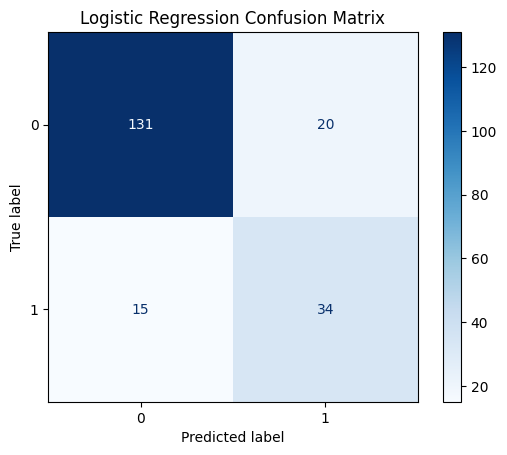

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Logistic Regression Confusion Matrix')

In [ ]:

import os, json, time, joblib
os.makedirs("models", exist_ok=True)


C_val = getattr(clf.named_steps['clf'], 'C', 1.0)
l1_ratio_val = getattr(clf.named_steps['clf'], 'l1_ratio', 0.5)

record = {
    "timestamp": time.strftime("%Y-%m-%dT%H:%M:%S"),
    "model": "ElasticNet",
    "seed": 42,
    "test_size": 0.20,
    "params": {"penalty":"elasticnet","C": float(C_val), "l1_ratio": float(l1_ratio_val)},

    "pr_auc": float(aps),     # = Average Precision (PR-AUC)
    "roc_auc": float(auc),    # ROC-AUC
    
    "test_metrics": {
        "accuracy": float(acc),
        "precision": float(prec),
        "recall": float(rec),
        "f1": float(f1),
        "average_precision": float(aps),
        "roc_auc": float(auc)
    }
}

with open("models/metrics.jsonl", "a", encoding="utf-8") as f:
    f.write(json.dumps(record) + "\n")


joblib.dump(clf, "models/elasticnet_best.joblib")

print("✔ Metrics appended to models/metrics.jsonl")
print("✔ Model saved to models/elasticnet_best.joblib")


✔ Metrics appended to models/metrics.jsonl
✔ Model saved to models/elasticnet_best.joblib
